<a href="https://colab.research.google.com/github/DavidReveloLuna/Bird_Classification-/blob/master/CustomClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [2]:
!git clone https://github.com/DavidReveloLuna/MaskRCNN_Video.git

Cloning into 'MaskRCNN_Video'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 122 (delta 45), reused 63 (delta 10), pack-reused 0
Receiving objects: 100% (122/122), 48.61 MiB | 29.77 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
cd MaskRCNN_Video/


/content/MaskRCNN_Video


In [4]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn

In [5]:
ROOT_DIR = '/content/MaskRCNN_Video'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [8]:
class CustomConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + objetos

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [10]:
class CustomDataset(utils.Dataset):
 
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "RBC")
        self.add_class("object", 2, "WBC")
 
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
 
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
          
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes']['objetos'] for s in a['regions'].values()]

            name_dict = {"RBC": 1,"WBC": 2}
            num_ids = [name_dict[a] for a in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            #print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
 
            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
 
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
 

In [13]:
dataset_train = CustomDataset()
dataset_train.load_custom("/content/MaskRCNN_Video/images", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("/content/MaskRCNN_Video/images", "train")
dataset_val.prepare()

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [15]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

6
/content/MaskRCNN_Video/images/train/image-17.png


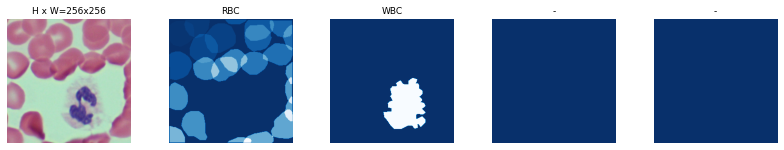

9
/content/MaskRCNN_Video/images/train/image-20.png


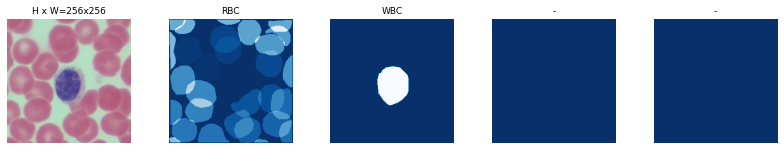

19
/content/MaskRCNN_Video/images/train/image-33.png


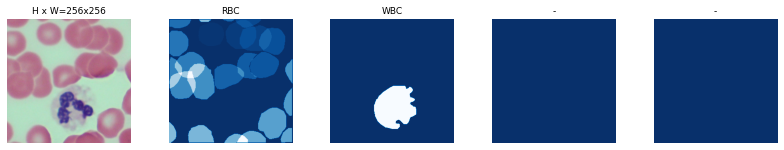

6
/content/MaskRCNN_Video/images/train/image-17.png


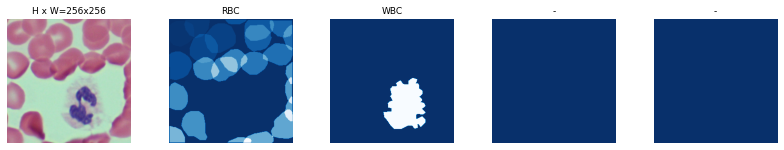

In [16]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(dataset.image_reference(image_id))
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  18 /content/MaskRCNN_Video/images/train/image-32.png
image                    shape: (256, 256, 3)         min:   40.00000  max:  227.00000  uint8
mask                     shape: (256, 256, 25)        min:    0.00000  max:    1.00000  uint8
class_ids                shape: (25,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (25, 4)               min:    0.00000  max:  256.00000  int32


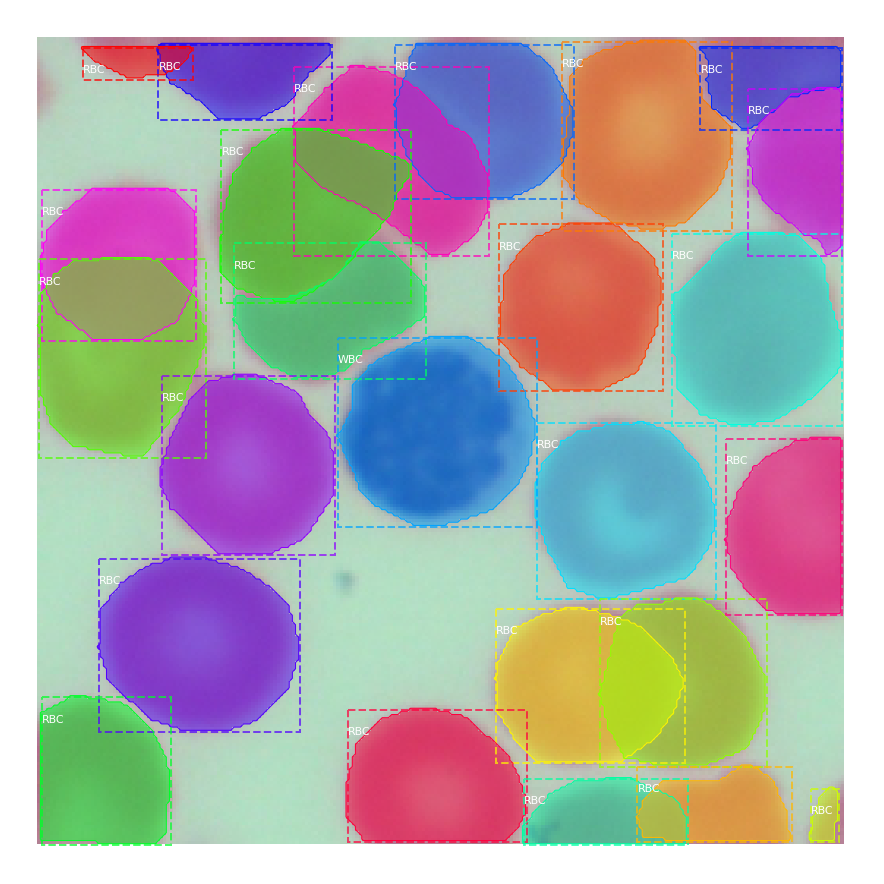

In [17]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [18]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/MaskRCNN_Video/logs/object20200927T1552/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.2286 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.2085 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.2425WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
500/500 [==============================] - 241s 482ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.2286 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.2085 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.2425 - val_loss: 0.7594 - val_rpn_class_loss: 0.0190 - val_rpn_bbox_loss: 0.3161 - val_mrcnn_class_loss: 0.1157 - val_mrcnn_bbox_loss: 0.1264 - val_mrcnn_mask_loss: 0.1821
Epoch 2/10
500/500

In [19]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.6
    

inference_config = InferenceConfig()



In [20]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)


Instructions for updating:
Use fn_output_signature instead


In [21]:
# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(ROOT_DIR, "/content/MaskRCNN_Video/logs/objetos20200926T1547/mask_rcnn_objetos_0010.h5")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/MaskRCNN_Video/logs/object20200927T1552/mask_rcnn_object_0010.h5
Re-starting from epoch 10


/content/MaskRCNN_Video/images/train/image-19.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  230.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.80000  max:  111.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


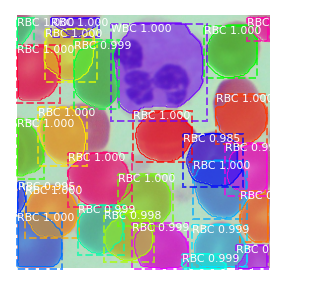

/content/MaskRCNN_Video/images/train/image-8.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   61.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.80000  max:  110.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


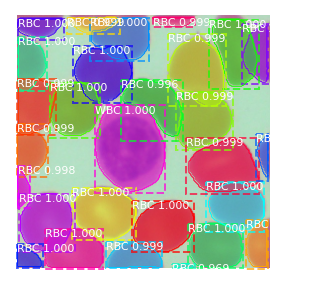

/content/MaskRCNN_Video/images/train/image-2.png
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


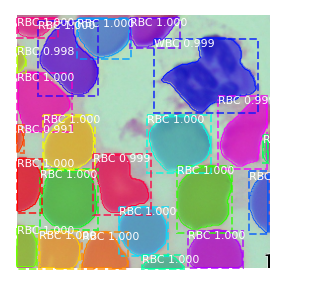

/content/MaskRCNN_Video/images/train/image-32.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.80000  max:  108.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


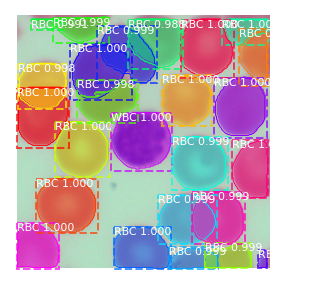

/content/MaskRCNN_Video/images/train/image-30.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   90.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -26.80000  max:  109.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


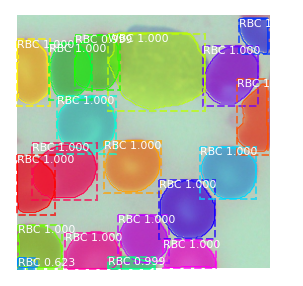

/content/MaskRCNN_Video/images/train/image-20.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.80000  max:  109.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


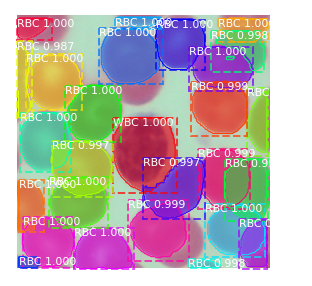

/content/MaskRCNN_Video/images/train/image-12.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   28.00000  max:  232.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.80000  max:  113.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


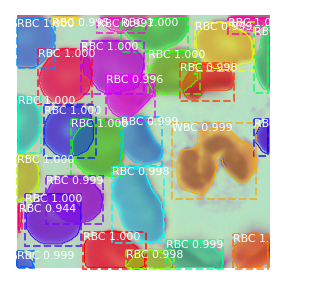

/content/MaskRCNN_Video/images/train/image-28.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   27.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.80000  max:  115.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


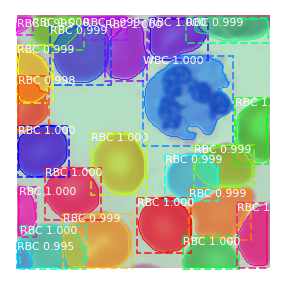

/content/MaskRCNN_Video/images/train/image-21.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   26.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.80000  max:  115.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


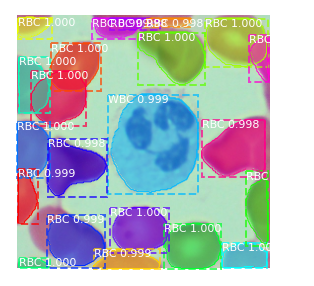

/content/MaskRCNN_Video/images/train/image-24.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   23.00000  max:  231.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.80000  max:  112.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


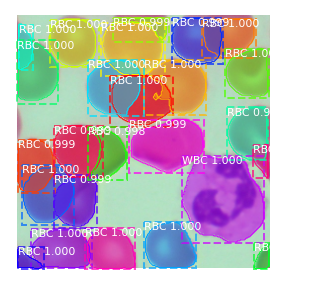

/content/MaskRCNN_Video/images/train/image-25.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   30.00000  max:  231.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.80000  max:  113.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


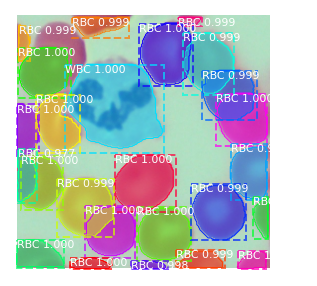

/content/MaskRCNN_Video/images/train/image-18.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.80000  max:  110.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


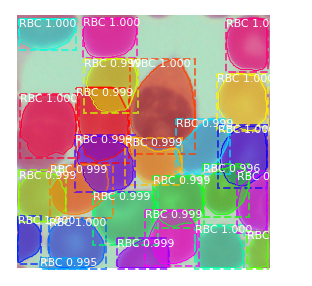

/content/MaskRCNN_Video/images/train/image-31.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   34.00000  max:  204.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:   99.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


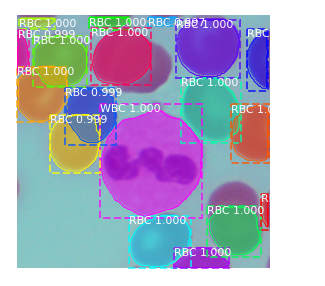

/content/MaskRCNN_Video/images/train/image-22.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   32.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.80000  max:  110.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


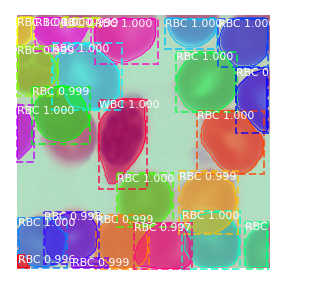

/content/MaskRCNN_Video/images/train/image-4.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   79.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -39.70000  max:  109.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


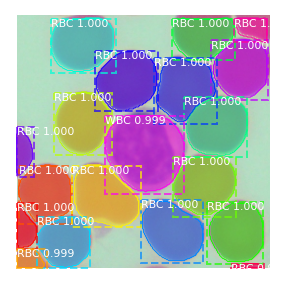

/content/MaskRCNN_Video/images/train/image-35.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   23.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.80000  max:  115.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


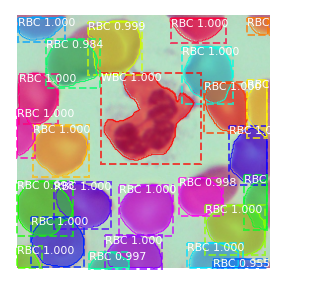

/content/MaskRCNN_Video/images/train/image-1.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   26.00000  max:  231.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.80000  max:  113.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


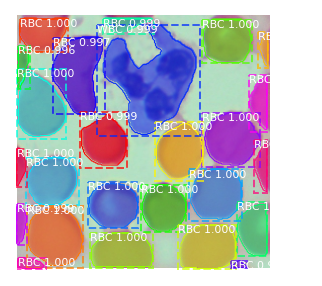

/content/MaskRCNN_Video/images/train/image-17.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   24.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.80000  max:  114.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


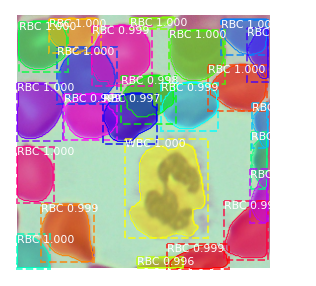

/content/MaskRCNN_Video/images/train/image-7.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  232.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.80000  max:  114.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


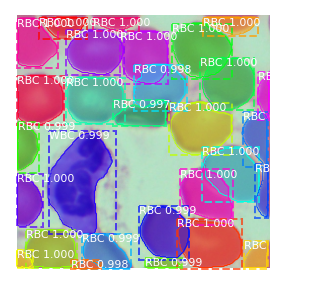

/content/MaskRCNN_Video/images/train/image-33.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   29.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.80000  max:  115.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


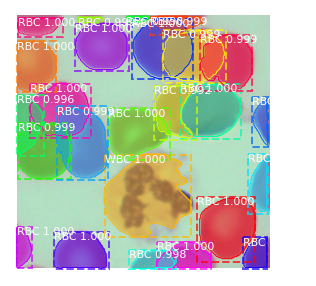

/content/MaskRCNN_Video/images/train/image-23.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   33.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.80000  max:  115.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


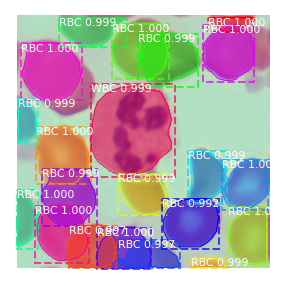

/content/MaskRCNN_Video/images/train/image-34.png
Processing 1 images
image                    shape: (256, 256, 3)         min:   42.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.80000  max:  110.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


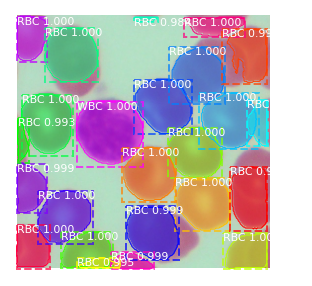

In [25]:
import skimage
import matplotlib.pyplot as plt

real_test_dir = '/content/MaskRCNN_Video/images/train/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    if img.ndim != 3:
      image = skimage.color.gray2rgb(img)
    if img.shape[-1] == 4:
      image = img[..., :3]

    print(image_path)
    img_arr = np.array(image)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
